##Bibliotecas

In [181]:
import pandas as pd
import os
import csv
import numpy as np
import json
import statsmodels.api as sm
from google.colab import files
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

###1 Carregando Dataframe SELIC e verificando existencia de valores nulos ou missing

In [182]:
selic_file = '/content/STP-20251001161617503_selic.csv'

try:
    df_selic = pd.read_csv(selic_file, on_bad_lines='skip', sep=',')
    print(f"Dataset {selic_file} carregado com sucesso com utf-8 e separador ','.")
except UnicodeDecodeError:
    df_selic = pd.read_csv(selic_file, encoding='latin1', on_bad_lines='skip', sep=',')
    print(f"Dataset {selic_file} carregado com sucesso com latin1 e separador ','.")
except Exception as e:
    print(f"Erro ao carregar o dataset {selic_file}: {e}")

original_selic_col_name = df_selic.columns[1]
df_selic = df_selic.rename(columns={original_selic_col_name: 'Taxa Selic - a.a.'})

df_selic['Data'] = pd.to_datetime(df_selic['Data'], format='%d/%m/%Y', errors='coerce')

df_selic.dropna(subset=['Data'], inplace=True)

print(f"\nPrimeiras 5 linhas do dataset {selic_file} CORRIGIDO:")
display(df_selic.head())
print(f"\nInformações do dataset {selic_file} CORRIGIDO:")
df_selic.info()


Dataset /content/STP-20251001161617503_selic.csv carregado com sucesso com utf-8 e separador ','.

Primeiras 5 linhas do dataset /content/STP-20251001161617503_selic.csv CORRIGIDO:


,Data,Taxa Selic - a.a.
0,2020-10-01,2
1,2020-10-02,2
2,2020-10-03,2
3,2020-10-04,2
4,2020-10-05,2



Informações do dataset /content/STP-20251001161617503_selic.csv CORRIGIDO:
<class 'pandas.core.frame.DataFrame'>
Index: 1827 entries, 0 to 1826
Data columns (total 2 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   Data               1827 non-null   datetime64[ns]
 1   Taxa Selic - a.a.  1827 non-null   object        
dtypes: datetime64[ns](1), object(1)
memory usage: 42.8+ KB


###2 Carregando Dataframe Taxa de Câmbio e tratando os dados

In [183]:
cambio_file = '/content/STP-20251001162317444_tx_cambio.csv'

metadados_cambio = {}
data_list = []
original_cambio_col_name = None

try:
    with open(cambio_file, 'r', encoding='latin1') as file:
        reader = csv.reader(file, delimiter=',')

        linha1 = next(reader)

        if len(linha1) > 1:
            original_cambio_col_name = linha1[1].strip()
        else:
            original_cambio_col_name = 'CAMBIO_DEFAULT'

        metadados_cambio = {
            'nome_original': original_cambio_col_name,
            'unidade': 'N/A'
        }

        for row in reader:
            if not row:
                continue

            if row[0].strip().lower().startswith('fonte'):
                break

            if len(row) >= 2:
                data_list.append([row[0].strip(), row[1].strip()])


    df_cambio = pd.DataFrame(data_list, columns=['Data', original_cambio_col_name])

except Exception as e:
    print(f"Erro ao carregar e processar o dataset {cambio_file}: {e}")
    df_cambio = pd.DataFrame(columns=['Data', 'CAMBIO_ERROR']) # Define a default empty df
    original_cambio_col_name = 'CAMBIO_ERROR' # Update col name for error state

if not df_cambio.empty:
    df_cambio['Data'] = pd.to_datetime(df_cambio['Data'], format='%d/%m/%Y', errors='coerce')
    df_cambio.dropna(subset=['Data'], inplace=True)

    if original_cambio_col_name in df_cambio.columns:
        df_cambio[original_cambio_col_name] = df_cambio[original_cambio_col_name].str.replace(',', '.', regex=False)
        df_cambio[original_cambio_col_name] = pd.to_numeric(df_cambio[original_cambio_col_name], errors='coerce')
        df_cambio.dropna(subset=[original_cambio_col_name], inplace=True)
    else:
        print(f"A coluna '{original_cambio_col_name}' não foi encontrada no DataFrame. Verifique o cabeçalho do arquivo.")
        df_cambio = pd.DataFrame(columns=['Data', original_cambio_col_name]) # Empty df if col not found
else:
    print("DataFrame df_cambio está vazio após o carregamento inicial.")

print("\n--- Metadados Documentados ---")
print(f"Nome da Série Original: {metadados_cambio.get('nome_original', original_cambio_col_name)}")
print(f"Unidade de Medida: {metadados_cambio.get('unidade', 'N/A')}")
print("------------------------------")

print(f"\nPrimeiras 5 linhas do dataframe {cambio_file} CORRIGIDO:")
display(df_cambio.head())

print(f"\nInformações do dataframe {cambio_file} CORRIGIDO:")
df_cambio.info()


--- Metadados Documentados ---
Nome da Série Original: Taxa de cambio - Livre - Dolar americano (venda) - diario - u.m.c./US$
Unidade de Medida: N/A
------------------------------

Primeiras 5 linhas do dataframe /content/STP-20251001162317444_tx_cambio.csv CORRIGIDO:


,Data,Taxa de cambio - Livre - Dolar americano (venda) - diario - u.m.c./US$
0,2020-10-01,5.6441
1,2020-10-02,5.6464
2,2020-10-05,5.6299
3,2020-10-06,5.5205
4,2020-10-07,5.6018



Informações do dataframe /content/STP-20251001162317444_tx_cambio.csv CORRIGIDO:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1256 entries, 0 to 1255
Data columns (total 2 columns):
 #   Column                                                                  Non-Null Count  Dtype         
---  ------                                                                  --------------  -----         
 0   Data                                                                    1256 non-null   datetime64[ns]
 1   Taxa de cambio - Livre - Dolar americano (venda) - diario - u.m.c./US$  1256 non-null   float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 19.8 KB


##3 Convertendo as colunas 'Data', do df_cambio, para datetime

In [184]:
df_cambio['Data'] = pd.to_datetime(df_cambio['Data'], format='%d/%m/%Y', errors='coerce')



##4 Filtrando df_selic para incluir apenas as datas presentes em df_cambio | Renomeando a coluna da SELIC no dataframe filtrado


In [185]:
df_selic_filtered = df_selic[df_selic['Data'].isin(df_cambio['Data'])].copy()

df_selic_filtered = df_selic_filtered.rename(columns={'432 - Taxa de juros - Meta Selic definida pelo Copom - % a.a.': 'Taxa Selic - a.a.'})



##5 Renomeando a coluna do dataframe Taxa de Cambio: df_cambio

In [186]:
df_cambio = df_cambio.rename(columns={'Taxa de cambio - Livre - Dolar americano (venda) - diario - u.m.c./US$': 'Taxa Cambio u.m.c./US$'})

##6 Realizando merge dos dataframes df_selic, df_cambio, tendo como referencia/índice a coluna 'Data'

##

In [187]:
merged_df_selic_cambio = pd.merge(
    df_selic_filtered[['Data', 'Taxa Selic - a.a.']],
    df_cambio[['Data', 'Taxa Cambio u.m.c./US$']],
    on='Data',
    how='inner'
)

print("\nPrimeiras linhas do dataset unido corretamente:")
display(merged_df_selic_cambio.head())
print("\nInformações do dataset unido corretamente:")
merged_df_selic_cambio.info()


Primeiras linhas do dataset unido corretamente:


,Data,Taxa Selic - a.a.,Taxa Cambio u.m.c./US$
0,2020-10-01,2,5.6441
1,2020-10-02,2,5.6464
2,2020-10-05,2,5.6299
3,2020-10-06,2,5.5205
4,2020-10-07,2,5.6018



Informações do dataset unido corretamente:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1256 entries, 0 to 1255
Data columns (total 3 columns):
 #   Column                  Non-Null Count  Dtype         
---  ------                  --------------  -----         
 0   Data                    1256 non-null   datetime64[ns]
 1   Taxa Selic - a.a.       1256 non-null   object        
 2   Taxa Cambio u.m.c./US$  1256 non-null   float64       
dtypes: datetime64[ns](1), float64(1), object(1)
memory usage: 29.6+ KB


###7 Unir o dataframe merge_df (df_selic + df_cambio) com dataframe referente aos preços do fechamento de ações do Itau, Petrobras e Vale do Rio Doce nos ultimos 5 anos. A coluna 'Data' será a referência/índice para esse procedimento.

In [188]:
df_preco = pd.read_csv('/content/precos_acoes_5anos.csv')
display(df_preco.head())
df_preco.info()

,Date,ITUB4,PETR4,VALE3
0,2020-10-02,15.752269,5.634552,35.470676
1,2020-10-05,15.919624,5.933758,36.243095
2,2020-10-06,15.947523,5.904132,35.653137
3,2020-10-07,15.828972,5.862660,36.595856
4,2020-10-08,16.784292,6.055218,37.277058


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1244 entries, 0 to 1243
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Date    1244 non-null   object 
 1   ITUB4   1244 non-null   float64
 2   PETR4   1244 non-null   float64
 3   VALE3   1244 non-null   float64
dtypes: float64(3), object(1)
memory usage: 39.0+ KB


##8 Garantir que a coluna 'Date' no dataframe df_preco esteja no formato datatime e nomeada como 'Data', seguindo o padrão dos dataframes anteriores. Proceder o merge entre os dataframes.

In [189]:
df_preco['Data'] = pd.to_datetime(df_preco['Date'])

df_preco_filtered = df_preco[df_preco['Data'].isin(merged_df_selic_cambio['Data'])].copy()

merged_df_selic_cambio_preco = pd.merge(
    merged_df_selic_cambio,
    df_preco_filtered[['Data', 'ITUB4', 'PETR4', 'VALE3']],
    on='Data',
    how='inner'
)

print("\nPrimeiras linhas do dataset final unido:")
display(merged_df_selic_cambio_preco.head())
print("\nInformações do dataset final unido:")
merged_df_selic_cambio_preco.info()
merged_df_selic_cambio_preco.tail()


Primeiras linhas do dataset final unido:


,Data,Taxa Selic - a.a.,Taxa Cambio u.m.c./US$,ITUB4,PETR4,VALE3
0,2020-10-02,2,5.6464,15.752269,5.634552,35.470676
1,2020-10-05,2,5.6299,15.919624,5.933758,36.243095
2,2020-10-06,2,5.5205,15.947523,5.904132,35.653137
3,2020-10-07,2,5.6018,15.828972,5.862660,36.595856
4,2020-10-08,2,5.6200,16.784292,6.055218,37.277058



Informações do dataset final unido:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1244 entries, 0 to 1243
Data columns (total 6 columns):
 #   Column                  Non-Null Count  Dtype         
---  ------                  --------------  -----         
 0   Data                    1244 non-null   datetime64[ns]
 1   Taxa Selic - a.a.       1244 non-null   object        
 2   Taxa Cambio u.m.c./US$  1244 non-null   float64       
 3   ITUB4                   1244 non-null   float64       
 4   PETR4                   1244 non-null   float64       
 5   VALE3                   1244 non-null   float64       
dtypes: datetime64[ns](1), float64(4), object(1)
memory usage: 58.4+ KB


,Data,Taxa Selic - a.a.,Taxa Cambio u.m.c./US$,ITUB4,PETR4,VALE3
1239,2025-09-25,15,5.3425,38.462616,32.360001,58.209999
1240,2025-09-26,15,5.3445,38.652531,32.250000,57.090000
1241,2025-09-29,15,5.3229,38.872433,31.809999,57.279999
1242,2025-09-30,15,5.3186,39.052349,31.459999,57.580002
1243,2025-10-01,15,5.3208,38.349998,31.379999,58.310001


###9 Unir dataframe merged_df_selic_cambio_preco com o Risco Brasil - CDS

###9.1 Realizar ajustes no frame Risco Brasil - CDS

In [190]:
df_risc = pd.read_csv('/content/Brasil_CDS_5anos_final.csv', sep=';')
print("Primeiras linhas do dataframe carregado corretamente:")
display(df_risc.head())
print("\nInformações do dataframe carregado corretamente:")
df_risc.info()
df_risc.isnull().sum()

Primeiras linhas do dataframe carregado corretamente:


,"Data,CDS"
0,"01.10.2025,""135,13"""
1,"30.09.2025,""135,81"""
2,"29.09.2025,""136,14"""
3,"26.09.2025,""137,8"""
4,"25.09.2025,""137,17"""



Informações do dataframe carregado corretamente:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1304 entries, 0 to 1303
Data columns (total 1 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   Data,CDS  1304 non-null   object
dtypes: object(1)
memory usage: 10.3+ KB


,0
"Data,CDS",0


In [191]:
df_risc[['Data', 'CDS']] = df_risc['Data,CDS'].str.split(',', n=1, expand=True)

df_risc['Data'] = pd.to_datetime(df_risc['Data'], format='%d.%m.%Y', errors='coerce')

df_risc['CDS'] = df_risc['CDS'].str.replace('"', '', regex=False)
df_risc['CDS'] = df_risc['CDS'].str.replace(',', '.', regex=False)
df_risc['CDS'] = pd.to_numeric(df_risc['CDS'], errors='coerce')

df_risc.drop(columns=['Data,CDS'], inplace=True)
df_risc.dropna(subset=['Data', 'CDS'], inplace=True)

print("\nPrimeiras linhas do dataset df_risc com as colunas 'Data' e 'CDS' corrigidas:")
display(df_risc.head())
print("\nInformações do dataset df_risc com as colunas 'Data' e 'CDS' corrigidas:")
df_risc.info()


Primeiras linhas do dataset df_risc com as colunas 'Data' e 'CDS' corrigidas:


,Data,CDS
0,2025-10-01,135.13
1,2025-09-30,135.81
2,2025-09-29,136.14
3,2025-09-26,137.80
4,2025-09-25,137.17



Informações do dataset df_risc com as colunas 'Data' e 'CDS' corrigidas:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1304 entries, 0 to 1303
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   Data    1304 non-null   datetime64[ns]
 1   CDS     1304 non-null   float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 20.5 KB


##9.2 Filtrar o dataframe merged_risk de modo que sejam incluidas apenas as datas do dataframe merged_df_selic_cambio_preco

In [192]:
merged_risc_filtered = df_risc[df_risc['Data'].isin(merged_df_selic_cambio_preco['Data'])].copy()
merged_risc_filtered.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1243 entries, 0 to 1302
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   Data    1243 non-null   datetime64[ns]
 1   CDS     1243 non-null   float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 29.1 KB


##9.3 Realizar o merge do dataframe merged_risk_filtered (CDS) com o dataframe merged_df_selic_cambio_preco

In [193]:
merged_df_selic_cambio_preco_cds = pd.merge(
    merged_df_selic_cambio_preco,
    merged_risc_filtered[['Data', 'CDS']],
    on='Data',
    how='inner'
)

display(merged_df_selic_cambio_preco_cds.head())
merged_df_selic_cambio_preco_cds.info()

,Data,Taxa Selic - a.a.,Taxa Cambio u.m.c./US$,ITUB4,PETR4,VALE3,CDS
0,2020-10-02,2,5.6464,15.752269,5.634552,35.470676,243.61
1,2020-10-05,2,5.6299,15.919624,5.933758,36.243095,231.25
2,2020-10-06,2,5.5205,15.947523,5.904132,35.653137,228.85
3,2020-10-07,2,5.6018,15.828972,5.862660,36.595856,224.85
4,2020-10-08,2,5.6200,16.784292,6.055218,37.277058,221.13


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1243 entries, 0 to 1242
Data columns (total 7 columns):
 #   Column                  Non-Null Count  Dtype         
---  ------                  --------------  -----         
 0   Data                    1243 non-null   datetime64[ns]
 1   Taxa Selic - a.a.       1243 non-null   object        
 2   Taxa Cambio u.m.c./US$  1243 non-null   float64       
 3   ITUB4                   1243 non-null   float64       
 4   PETR4                   1243 non-null   float64       
 5   VALE3                   1243 non-null   float64       
 6   CDS                     1243 non-null   float64       
dtypes: datetime64[ns](1), float64(5), object(1)
memory usage: 68.1+ KB


##9.4 Verificar a ordem das colunas do dataframe merged_df_selic_cambio_preco_cds e proceder reorganização

In [194]:
current_cols = merged_df_selic_cambio_preco_cds.columns.tolist()
display(current_cols)

desired_order = [
    'Data',
    'Taxa Selic - a.a.',
    'Taxa Cambio u.m.c./US$',
    'CDS',
    'ITUB4',
    'PETR4',
    'VALE3'
]

merged_dfs_columns_ordered = merged_df_selic_cambio_preco_cds.reindex(columns=desired_order)

print("\nPrimeiras linhas do dataset final com colunas reordenadas:")
display(merged_dfs_columns_ordered.head())
print("\nInformações do dataset final com colunas reordenadas:")
merged_dfs_columns_ordered.info()

['Data',
 'Taxa Selic - a.a.',
 'Taxa Cambio u.m.c./US$',
 'ITUB4',
 'PETR4',
 'VALE3',
 'CDS']


Primeiras linhas do dataset final com colunas reordenadas:


,Data,Taxa Selic - a.a.,Taxa Cambio u.m.c./US$,CDS,ITUB4,PETR4,VALE3
0,2020-10-02,2,5.6464,243.61,15.752269,5.634552,35.470676
1,2020-10-05,2,5.6299,231.25,15.919624,5.933758,36.243095
2,2020-10-06,2,5.5205,228.85,15.947523,5.904132,35.653137
3,2020-10-07,2,5.6018,224.85,15.828972,5.862660,36.595856
4,2020-10-08,2,5.6200,221.13,16.784292,6.055218,37.277058



Informações do dataset final com colunas reordenadas:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1243 entries, 0 to 1242
Data columns (total 7 columns):
 #   Column                  Non-Null Count  Dtype         
---  ------                  --------------  -----         
 0   Data                    1243 non-null   datetime64[ns]
 1   Taxa Selic - a.a.       1243 non-null   object        
 2   Taxa Cambio u.m.c./US$  1243 non-null   float64       
 3   CDS                     1243 non-null   float64       
 4   ITUB4                   1243 non-null   float64       
 5   PETR4                   1243 non-null   float64       
 6   VALE3                   1243 non-null   float64       
dtypes: datetime64[ns](1), float64(5), object(1)
memory usage: 68.1+ KB


##9.5 Renomear colunas para os nomes reais das companhias

In [195]:
merged_dfs = merged_dfs_columns_ordered.rename(columns={
    'ITUB4': 'Itau',
    'PETR4': 'Petrobras',
    'VALE3': 'Vale Rio Doce'
})

print("\nPrimeiras linhas do dataframe final com colunas de ações renomeadas:")
display(merged_dfs.head())
print("\nInformações do dataframe final com colunas de ações renomeadas:")
merged_dfs.info()



Primeiras linhas do dataframe final com colunas de ações renomeadas:


,Data,Taxa Selic - a.a.,Taxa Cambio u.m.c./US$,CDS,Itau,Petrobras,Vale Rio Doce
0,2020-10-02,2,5.6464,243.61,15.752269,5.634552,35.470676
1,2020-10-05,2,5.6299,231.25,15.919624,5.933758,36.243095
2,2020-10-06,2,5.5205,228.85,15.947523,5.904132,35.653137
3,2020-10-07,2,5.6018,224.85,15.828972,5.862660,36.595856
4,2020-10-08,2,5.6200,221.13,16.784292,6.055218,37.277058



Informações do dataframe final com colunas de ações renomeadas:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1243 entries, 0 to 1242
Data columns (total 7 columns):
 #   Column                  Non-Null Count  Dtype         
---  ------                  --------------  -----         
 0   Data                    1243 non-null   datetime64[ns]
 1   Taxa Selic - a.a.       1243 non-null   object        
 2   Taxa Cambio u.m.c./US$  1243 non-null   float64       
 3   CDS                     1243 non-null   float64       
 4   Itau                    1243 non-null   float64       
 5   Petrobras               1243 non-null   float64       
 6   Vale Rio Doce           1243 non-null   float64       
dtypes: datetime64[ns](1), float64(5), object(1)
memory usage: 68.1+ KB


In [196]:
merged_dfs['CDS'] = merged_dfs['CDS'].astype(str).str.replace(',', '.', regex=False)

merged_dfs['CDS'] = merged_dfs['CDS'].astype(float)

merged_dfs.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1243 entries, 0 to 1242
Data columns (total 7 columns):
 #   Column                  Non-Null Count  Dtype         
---  ------                  --------------  -----         
 0   Data                    1243 non-null   datetime64[ns]
 1   Taxa Selic - a.a.       1243 non-null   object        
 2   Taxa Cambio u.m.c./US$  1243 non-null   float64       
 3   CDS                     1243 non-null   float64       
 4   Itau                    1243 non-null   float64       
 5   Petrobras               1243 non-null   float64       
 6   Vale Rio Doce           1243 non-null   float64       
dtypes: datetime64[ns](1), float64(5), object(1)
memory usage: 68.1+ KB


##9.6 Transformar tipo de dados da Taxa Selic em numero

In [197]:
col = merged_dfs[
    'Taxa Selic - a.a.'
].astype(str)

# limpar espaço
col = col.str.strip()

# remover símbolo %
col = col.str.replace('%', '', regex=False)

# trocar vírgula por ponto
col = col.str.replace(',', '.', regex=False)

# remover strings vazias
col = col.replace('', None)

# converter
merged_dfs[
    'Taxa Selic - a.a.'
] = pd.to_numeric(col, errors='coerce')

#display resultado
merged_dfs.info()
display(merged_dfs)


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1243 entries, 0 to 1242
Data columns (total 7 columns):
 #   Column                  Non-Null Count  Dtype         
---  ------                  --------------  -----         
 0   Data                    1243 non-null   datetime64[ns]
 1   Taxa Selic - a.a.       1243 non-null   float64       
 2   Taxa Cambio u.m.c./US$  1243 non-null   float64       
 3   CDS                     1243 non-null   float64       
 4   Itau                    1243 non-null   float64       
 5   Petrobras               1243 non-null   float64       
 6   Vale Rio Doce           1243 non-null   float64       
dtypes: datetime64[ns](1), float64(6)
memory usage: 68.1 KB


,Data,Taxa Selic - a.a.,Taxa Cambio u.m.c./US$,CDS,Itau,Petrobras,Vale Rio Doce
0,2020-10-02,2.0,5.6464,243.61,15.752269,5.634552,35.470676
1,2020-10-05,2.0,5.6299,231.25,15.919624,5.933758,36.243095
2,2020-10-06,2.0,5.5205,228.85,15.947523,5.904132,35.653137
3,2020-10-07,2.0,5.6018,224.85,15.828972,5.862660,36.595856
4,2020-10-08,2.0,5.6200,221.13,16.784292,6.055218,37.277058
...,...,...,...,...,...,...,...
1238,2025-09-25,15.0,5.3425,137.17,38.462616,32.360001,58.209999
1239,2025-09-26,15.0,5.3445,137.80,38.652531,32.250000,57.090000
1240,2025-09-29,15.0,5.3229,136.14,38.872433,31.809999,57.279999
1241,2025-09-30,15.0,5.3186,135.81,39.052349,31.459999,57.580002


##9.7 Ajustar escala da coluna Taxa Selic (Dividir por 100)

In [198]:
# Correção da escala da Selic
merged_dfs['Taxa Selic - a.a.'] = merged_dfs['Taxa Selic - a.a.'] / 100

# Verificação
display(merged_dfs['Taxa Selic - a.a.'].head())
merged_dfs.info()
display(merged_dfs)

,Taxa Selic - a.a.
0,0.02
1,0.02
2,0.02
3,0.02
4,0.02


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1243 entries, 0 to 1242
Data columns (total 7 columns):
 #   Column                  Non-Null Count  Dtype         
---  ------                  --------------  -----         
 0   Data                    1243 non-null   datetime64[ns]
 1   Taxa Selic - a.a.       1243 non-null   float64       
 2   Taxa Cambio u.m.c./US$  1243 non-null   float64       
 3   CDS                     1243 non-null   float64       
 4   Itau                    1243 non-null   float64       
 5   Petrobras               1243 non-null   float64       
 6   Vale Rio Doce           1243 non-null   float64       
dtypes: datetime64[ns](1), float64(6)
memory usage: 68.1 KB


,Data,Taxa Selic - a.a.,Taxa Cambio u.m.c./US$,CDS,Itau,Petrobras,Vale Rio Doce
0,2020-10-02,0.02,5.6464,243.61,15.752269,5.634552,35.470676
1,2020-10-05,0.02,5.6299,231.25,15.919624,5.933758,36.243095
2,2020-10-06,0.02,5.5205,228.85,15.947523,5.904132,35.653137
3,2020-10-07,0.02,5.6018,224.85,15.828972,5.862660,36.595856
4,2020-10-08,0.02,5.6200,221.13,16.784292,6.055218,37.277058
...,...,...,...,...,...,...,...
1238,2025-09-25,0.15,5.3425,137.17,38.462616,32.360001,58.209999
1239,2025-09-26,0.15,5.3445,137.80,38.652531,32.250000,57.090000
1240,2025-09-29,0.15,5.3229,136.14,38.872433,31.809999,57.279999
1241,2025-09-30,0.15,5.3186,135.81,39.052349,31.459999,57.580002


In [199]:
merged_dfs['Taxa Cambio u.m.c./US$'] = merged_dfs['Taxa Cambio u.m.c./US$'].round(4)
merged_dfs['Itau'] = merged_dfs['Itau'].round(2)
merged_dfs['Petrobras'] = merged_dfs['Petrobras'].round(2)
merged_dfs['Vale Rio Doce'] = merged_dfs['Vale Rio Doce'].round(2)

print("DataFrame 'merged_dfs' com colunas arredondadas para 2 casas decimais:")
display(merged_dfs.head())


DataFrame 'merged_dfs' com colunas arredondadas para 2 casas decimais:


,Data,Taxa Selic - a.a.,Taxa Cambio u.m.c./US$,CDS,Itau,Petrobras,Vale Rio Doce
0,2020-10-02,0.02,5.6464,243.61,15.75,5.63,35.47
1,2020-10-05,0.02,5.6299,231.25,15.92,5.93,36.24
2,2020-10-06,0.02,5.5205,228.85,15.95,5.90,35.65
3,2020-10-07,0.02,5.6018,224.85,15.83,5.86,36.60
4,2020-10-08,0.02,5.6200,221.13,16.78,6.06,37.28


##10 Salvar dataframe parcial

In [200]:
output_file_name = 'parcial_merged_dfs_cds.csv'
merged_dfs.to_csv(output_file_name, index=False)

print(f"\nDataframe parcial salvo localmente como: {output_file_name}")

files.download(output_file_name)


Dataframe parcial salvo localmente como: parcial_merged_dfs_cds.csv


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

##11 Carregar dataframe parcial (parcial_merged_dfs) e calcular o retorno logaritmo das ações do itaú, Petrobras, Vale do Rio Doce

In [201]:
try:
    final_merged_df = pd.read_csv('/content/parcial_merged_dfs_cds.csv')
    final_merged_df['Data'] = pd.to_datetime(final_merged_df['Data'])
    final_merged_df = final_merged_df.sort_values('Data')
except FileNotFoundError:
    print("Certifique-se de que o arquivo final_merged_dataset.csv está disponível.")

acoes = ['Itau', 'Petrobras', 'Vale Rio Doce']

for acao in acoes:

    final_merged_df[f'RETORNO_LOG_{acao}'] = np.log(
        final_merged_df[acao] / final_merged_df[acao].shift(1)
    )

final_merged_df = final_merged_df.dropna(subset=[f'RETORNO_LOG_{acao}' for acao in acoes])

print("DataFrame com as novas colunas de Retorno Logarítmico:")
final_merged_df_with_returns = final_merged_df[[
    'Data', 'Taxa Selic - a.a.', 'Taxa Cambio u.m.c./US$', 'CDS', 'Itau', 'RETORNO_LOG_Itau',
    'Petrobras', 'RETORNO_LOG_Petrobras',
    'Vale Rio Doce', 'RETORNO_LOG_Vale Rio Doce']]

display(final_merged_df_with_returns.head())
final_merged_df_with_returns.info()

DataFrame com as novas colunas de Retorno Logarítmico:


,Data,Taxa Selic - a.a.,Taxa Cambio u.m.c./US$,CDS,Itau,RETORNO_LOG_Itau,Petrobras,RETORNO_LOG_Petrobras,Vale Rio Doce,RETORNO_LOG_Vale Rio Doce
1,2020-10-05,0.02,5.6299,231.25,15.92,0.010736,5.93,0.051915,36.24,0.021476
2,2020-10-06,0.02,5.5205,228.85,15.95,0.001883,5.90,-0.005072,35.65,-0.016414
3,2020-10-07,0.02,5.6018,224.85,15.83,-0.007552,5.86,-0.006803,36.60,0.026299
4,2020-10-08,0.02,5.6200,221.13,16.78,0.058281,6.06,0.033560,37.28,0.018409
5,2020-10-09,0.02,5.5393,213.87,16.74,-0.002387,5.87,-0.031855,37.47,0.005084


<class 'pandas.core.frame.DataFrame'>
Index: 1242 entries, 1 to 1242
Data columns (total 10 columns):
 #   Column                     Non-Null Count  Dtype         
---  ------                     --------------  -----         
 0   Data                       1242 non-null   datetime64[ns]
 1   Taxa Selic - a.a.          1242 non-null   float64       
 2   Taxa Cambio u.m.c./US$     1242 non-null   float64       
 3   CDS                        1242 non-null   float64       
 4   Itau                       1242 non-null   float64       
 5   RETORNO_LOG_Itau           1242 non-null   float64       
 6   Petrobras                  1242 non-null   float64       
 7   RETORNO_LOG_Petrobras      1242 non-null   float64       
 8   Vale Rio Doce              1242 non-null   float64       
 9   RETORNO_LOG_Vale Rio Doce  1242 non-null   float64       
dtypes: datetime64[ns](1), float64(9)
memory usage: 106.7 KB


In [202]:
for acao in acoes:
    final_merged_df_with_returns[f'RETORNO_LOG_{acao}'] = final_merged_df_with_returns[f'RETORNO_LOG_{acao}'].round(6)

print("DataFrame com as colunas de Retorno Logarítmico arredondadas:")
display(final_merged_df_with_returns.head())
display(final_merged_df_with_returns.tail())

DataFrame com as colunas de Retorno Logarítmico arredondadas:


,Data,Taxa Selic - a.a.,Taxa Cambio u.m.c./US$,CDS,Itau,RETORNO_LOG_Itau,Petrobras,RETORNO_LOG_Petrobras,Vale Rio Doce,RETORNO_LOG_Vale Rio Doce
1,2020-10-05,0.02,5.6299,231.25,15.92,0.010736,5.93,0.051915,36.24,0.021476
2,2020-10-06,0.02,5.5205,228.85,15.95,0.001883,5.90,-0.005072,35.65,-0.016414
3,2020-10-07,0.02,5.6018,224.85,15.83,-0.007552,5.86,-0.006803,36.60,0.026299
4,2020-10-08,0.02,5.6200,221.13,16.78,0.058281,6.06,0.033560,37.28,0.018409
5,2020-10-09,0.02,5.5393,213.87,16.74,-0.002387,5.87,-0.031855,37.47,0.005084


,Data,Taxa Selic - a.a.,Taxa Cambio u.m.c./US$,CDS,Itau,RETORNO_LOG_Itau,Petrobras,RETORNO_LOG_Petrobras,Vale Rio Doce,RETORNO_LOG_Vale Rio Doce
1238,2025-09-25,0.15,5.3425,137.17,38.46,-0.008028,32.36,-0.008003,58.21,0.005513
1239,2025-09-26,0.15,5.3445,137.80,38.65,0.004928,32.25,-0.003405,57.09,-0.019428
1240,2025-09-29,0.15,5.3229,136.14,38.87,0.005676,31.81,-0.013737,57.28,0.003323
1241,2025-09-30,0.15,5.3186,135.81,39.05,0.004620,31.46,-0.011064,57.58,0.005224
1242,2025-10-01,0.15,5.3208,135.13,38.35,-0.018088,31.38,-0.002546,58.31,0.012598


##12 Salvar dataframe final com os retornos logaritmos

In [203]:
output_file_name = 'final_merged_dfs_with_log_returns.csv'
final_merged_df_with_returns.to_csv(output_file_name, index=False)

print(f"\nDataset final salvo localmente como: {output_file_name}")

files.download(output_file_name)


Dataset final salvo localmente como: final_merged_dfs_with_log_returns.csv


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

##13 Carregar dataframe final

In [204]:
df_with_returns = pd.read_csv('/content/final_merged_dfs_with_log_returns.csv')

print("\nPrimeiras linhas do dataset com retornos logarítmicos:")
display(df_with_returns.head())
df_with_returns.info()



Primeiras linhas do dataset com retornos logarítmicos:


,Data,Taxa Selic - a.a.,Taxa Cambio u.m.c./US$,CDS,Itau,RETORNO_LOG_Itau,Petrobras,RETORNO_LOG_Petrobras,Vale Rio Doce,RETORNO_LOG_Vale Rio Doce
0,2020-10-05,0.02,5.6299,231.25,15.92,0.010736,5.93,0.051915,36.24,0.021476
1,2020-10-06,0.02,5.5205,228.85,15.95,0.001883,5.90,-0.005072,35.65,-0.016414
2,2020-10-07,0.02,5.6018,224.85,15.83,-0.007552,5.86,-0.006803,36.60,0.026299
3,2020-10-08,0.02,5.6200,221.13,16.78,0.058281,6.06,0.033560,37.28,0.018409
4,2020-10-09,0.02,5.5393,213.87,16.74,-0.002387,5.87,-0.031855,37.47,0.005084


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1242 entries, 0 to 1241
Data columns (total 10 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Data                       1242 non-null   object 
 1   Taxa Selic - a.a.          1242 non-null   float64
 2   Taxa Cambio u.m.c./US$     1242 non-null   float64
 3   CDS                        1242 non-null   float64
 4   Itau                       1242 non-null   float64
 5   RETORNO_LOG_Itau           1242 non-null   float64
 6   Petrobras                  1242 non-null   float64
 7   RETORNO_LOG_Petrobras      1242 non-null   float64
 8   Vale Rio Doce              1242 non-null   float64
 9   RETORNO_LOG_Vale Rio Doce  1242 non-null   float64
dtypes: float64(9), object(1)
memory usage: 97.2+ KB


##14 Colocando o dataframe final em uma variável

In [205]:
df = df_with_returns.copy()


df['Data'] = pd.to_datetime(df['Data'])
df = df.sort_values('Data')
display(df)
display(df.info())


,Data,Taxa Selic - a.a.,Taxa Cambio u.m.c./US$,CDS,Itau,RETORNO_LOG_Itau,Petrobras,RETORNO_LOG_Petrobras,Vale Rio Doce,RETORNO_LOG_Vale Rio Doce
0,2020-10-05,0.02,5.6299,231.25,15.92,0.010736,5.93,0.051915,36.24,0.021476
1,2020-10-06,0.02,5.5205,228.85,15.95,0.001883,5.90,-0.005072,35.65,-0.016414
2,2020-10-07,0.02,5.6018,224.85,15.83,-0.007552,5.86,-0.006803,36.60,0.026299
3,2020-10-08,0.02,5.6200,221.13,16.78,0.058281,6.06,0.033560,37.28,0.018409
4,2020-10-09,0.02,5.5393,213.87,16.74,-0.002387,5.87,-0.031855,37.47,0.005084
...,...,...,...,...,...,...,...,...,...,...
1237,2025-09-25,0.15,5.3425,137.17,38.46,-0.008028,32.36,-0.008003,58.21,0.005513
1238,2025-09-26,0.15,5.3445,137.80,38.65,0.004928,32.25,-0.003405,57.09,-0.019428
1239,2025-09-29,0.15,5.3229,136.14,38.87,0.005676,31.81,-0.013737,57.28,0.003323
1240,2025-09-30,0.15,5.3186,135.81,39.05,0.004620,31.46,-0.011064,57.58,0.005224


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1242 entries, 0 to 1241
Data columns (total 10 columns):
 #   Column                     Non-Null Count  Dtype         
---  ------                     --------------  -----         
 0   Data                       1242 non-null   datetime64[ns]
 1   Taxa Selic - a.a.          1242 non-null   float64       
 2   Taxa Cambio u.m.c./US$     1242 non-null   float64       
 3   CDS                        1242 non-null   float64       
 4   Itau                       1242 non-null   float64       
 5   RETORNO_LOG_Itau           1242 non-null   float64       
 6   Petrobras                  1242 non-null   float64       
 7   RETORNO_LOG_Petrobras      1242 non-null   float64       
 8   Vale Rio Doce              1242 non-null   float64       
 9   RETORNO_LOG_Vale Rio Doce  1242 non-null   float64       
dtypes: datetime64[ns](1), float64(9)
memory usage: 97.2 KB


None

#15 Modelo de Regressão Linear Múltipla: Preparação

###Antes de executar o modelo preditivo, observou-se a necessidade de ajustar o dataframe final, incluindo 'RETORNO_LOG_CAMBIO', 'RETORNO_LOG_CDS'. Motivo?
- A transformação de preços/taxas em retornos logarítmicos (valores relativos) é fundamental porque, para fins de modelagem financeira e econométrica (como regressão e modelos de risco), é necessário trabalhar com a variação percentual dos ativos e não com seus valores absolutos.

Exceção?

O cálculo do "retorno logarítmico" para Selic resultaria na variação diária percentual da taxa anual, o que é uma variável difícil de interpretar no contexto de retornos diários de ativos e não seria o que a teoria econômica geralmente sugere (que é o nível da taxa de juros).

Conclusão: A Selic é uma variável de taxa de juros nominal de natureza diferente dos preços de mercado. Ela é usada em sua forma original para medir o efeito do nível da política monetária nos retornos dos ativos.

##15.1 Tratamento dos fatores macro. Converter colunas da taxa de cambio e cds em retornos logaritmos. Incluir retornos ao dataframe

In [206]:
df['RETORNO_LOG_CAMBIO'] = np.log(df['Taxa Cambio u.m.c./US$'] /
                                  df['Taxa Cambio u.m.c./US$'].shift(1))

df['RETORNO_LOG_CDS'] = np.log(df['CDS'] /
                                 df['CDS'].shift(1))


In [207]:
df['RETORNO_LOG_CAMBIO'] = df['RETORNO_LOG_CAMBIO'].round(6)
df['RETORNO_LOG_CDS'] = df['RETORNO_LOG_CDS'].round(6)
display(df)

,Data,Taxa Selic - a.a.,Taxa Cambio u.m.c./US$,CDS,Itau,RETORNO_LOG_Itau,Petrobras,RETORNO_LOG_Petrobras,Vale Rio Doce,RETORNO_LOG_Vale Rio Doce,RETORNO_LOG_CAMBIO,RETORNO_LOG_CDS
0,2020-10-05,0.02,5.6299,231.25,15.92,0.010736,5.93,0.051915,36.24,0.021476,NaN,NaN
1,2020-10-06,0.02,5.5205,228.85,15.95,0.001883,5.90,-0.005072,35.65,-0.016414,-0.019623,-0.010433
2,2020-10-07,0.02,5.6018,224.85,15.83,-0.007552,5.86,-0.006803,36.60,0.026299,0.014620,-0.017633
3,2020-10-08,0.02,5.6200,221.13,16.78,0.058281,6.06,0.033560,37.28,0.018409,0.003244,-0.016683
4,2020-10-09,0.02,5.5393,213.87,16.74,-0.002387,5.87,-0.031855,37.47,0.005084,-0.014464,-0.033382
...,...,...,...,...,...,...,...,...,...,...,...,...
1237,2025-09-25,0.15,5.3425,137.17,38.46,-0.008028,32.36,-0.008003,58.21,0.005513,0.005876,0.018394
1238,2025-09-26,0.15,5.3445,137.80,38.65,0.004928,32.25,-0.003405,57.09,-0.019428,0.000374,0.004582
1239,2025-09-29,0.15,5.3229,136.14,38.87,0.005676,31.81,-0.013737,57.28,0.003323,-0.004050,-0.012120
1240,2025-09-30,0.15,5.3186,135.81,39.05,0.004620,31.46,-0.011064,57.58,0.005224,-0.000808,-0.002427


##15.2 Remover linhas com NaN geradas pelos cálculos de retorno/choque E pela conversão da Selic. Definir variáveis independentes X. Salvar dataframe como csv.

In [208]:
df = df.dropna(subset=['Taxa Selic - a.a.', 'RETORNO_LOG_CAMBIO', 'RETORNO_LOG_CDS'] + [col for col in df.columns if col.startswith('RETORNO_LOG_')])

X = df[['Taxa Selic - a.a.', 'RETORNO_LOG_CAMBIO', 'RETORNO_LOG_CDS']]
X = sm.add_constant(X)




##15.3 Salvar dataframe final com os ajustes necessários ao modelo preditivo, incluindo 'RETORNO_LOG_CAMBIO', 'RETORNO_LOG_CDS': df_final_model

In [209]:
#Salvar de novo
df_final = df.copy()
display(df_final)
display(df_final.info())
output_file_name = 'df_final_model.csv'
df_final.to_csv(output_file_name, index=False)

print(f"\nDataset final usado no modelo salvo localmente como: {output_file_name}")

files.download(output_file_name)

,Data,Taxa Selic - a.a.,Taxa Cambio u.m.c./US$,CDS,Itau,RETORNO_LOG_Itau,Petrobras,RETORNO_LOG_Petrobras,Vale Rio Doce,RETORNO_LOG_Vale Rio Doce,RETORNO_LOG_CAMBIO,RETORNO_LOG_CDS
1,2020-10-06,0.02,5.5205,228.85,15.95,0.001883,5.90,-0.005072,35.65,-0.016414,-0.019623,-0.010433
2,2020-10-07,0.02,5.6018,224.85,15.83,-0.007552,5.86,-0.006803,36.60,0.026299,0.014620,-0.017633
3,2020-10-08,0.02,5.6200,221.13,16.78,0.058281,6.06,0.033560,37.28,0.018409,0.003244,-0.016683
4,2020-10-09,0.02,5.5393,213.87,16.74,-0.002387,5.87,-0.031855,37.47,0.005084,-0.014464,-0.033382
5,2020-10-13,0.02,5.5859,216.48,16.58,-0.009604,5.96,0.015216,37.79,0.008504,0.008377,0.012130
...,...,...,...,...,...,...,...,...,...,...,...,...
1237,2025-09-25,0.15,5.3425,137.17,38.46,-0.008028,32.36,-0.008003,58.21,0.005513,0.005876,0.018394
1238,2025-09-26,0.15,5.3445,137.80,38.65,0.004928,32.25,-0.003405,57.09,-0.019428,0.000374,0.004582
1239,2025-09-29,0.15,5.3229,136.14,38.87,0.005676,31.81,-0.013737,57.28,0.003323,-0.004050,-0.012120
1240,2025-09-30,0.15,5.3186,135.81,39.05,0.004620,31.46,-0.011064,57.58,0.005224,-0.000808,-0.002427


<class 'pandas.core.frame.DataFrame'>
Index: 1241 entries, 1 to 1241
Data columns (total 12 columns):
 #   Column                     Non-Null Count  Dtype         
---  ------                     --------------  -----         
 0   Data                       1241 non-null   datetime64[ns]
 1   Taxa Selic - a.a.          1241 non-null   float64       
 2   Taxa Cambio u.m.c./US$     1241 non-null   float64       
 3   CDS                        1241 non-null   float64       
 4   Itau                       1241 non-null   float64       
 5   RETORNO_LOG_Itau           1241 non-null   float64       
 6   Petrobras                  1241 non-null   float64       
 7   RETORNO_LOG_Petrobras      1241 non-null   float64       
 8   Vale Rio Doce              1241 non-null   float64       
 9   RETORNO_LOG_Vale Rio Doce  1241 non-null   float64       
 10  RETORNO_LOG_CAMBIO         1241 non-null   float64       
 11  RETORNO_LOG_CDS            1241 non-null   float64       
dtypes: datetime

None


Dataset final usado no modelo salvo localmente como: df_final_model.csv


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

##16 GRÁFICOS

###16.1 Gráficos de Série Temporal dos Fatores Macroeconômicos

A análise dos gráficos de série temporal dos fatores macroeconômicos (Taxa Selic, Taxa de Câmbio e CDS) revela insights importantes sobre a evolução econômica ao longo do período.

Taxa Selic (Política Monetária)
A série temporal da Selic mostra uma política monetária cíclica:

- Início: Período de taxas baixas (política expansionista) para estimular a economia.

- Meio: Elevação significativa e rápida das taxas, refletindo uma ação do COPOM para conter a inflação ou estabilizar o cenário macroeconômico.

- Final: Taxa se mantém em um patamar mais elevado.

Taxa de Câmbio (U.M.C./US$)
O gráfico do Câmbio é caracterizado por volatilidade considerável:

- Foram observados momentos de forte desvalorização da moeda nacional (aumento da taxa), possivelmente causados por instabilidade política ou incertezas econômicas (globais e internas).

- A série temporal exibe sensibilidade a choques, com picos e vales que marcam a reação da moeda a eventos críticos.

CDS (Risco Brasil - Percepção de Risco)
A série do CDS, que mede o risco-país, demonstra uma melhora na confiança ao longo do tempo:

- Início: Nível de risco mais elevado, associado a um cenário de maior fragilidade.

- Tendência Geral: Queda gradual do CDS ao longo do período, sugerindo uma melhora na confiança dos investidores na capacidade do Brasil de cumprir suas obrigações financeiras.

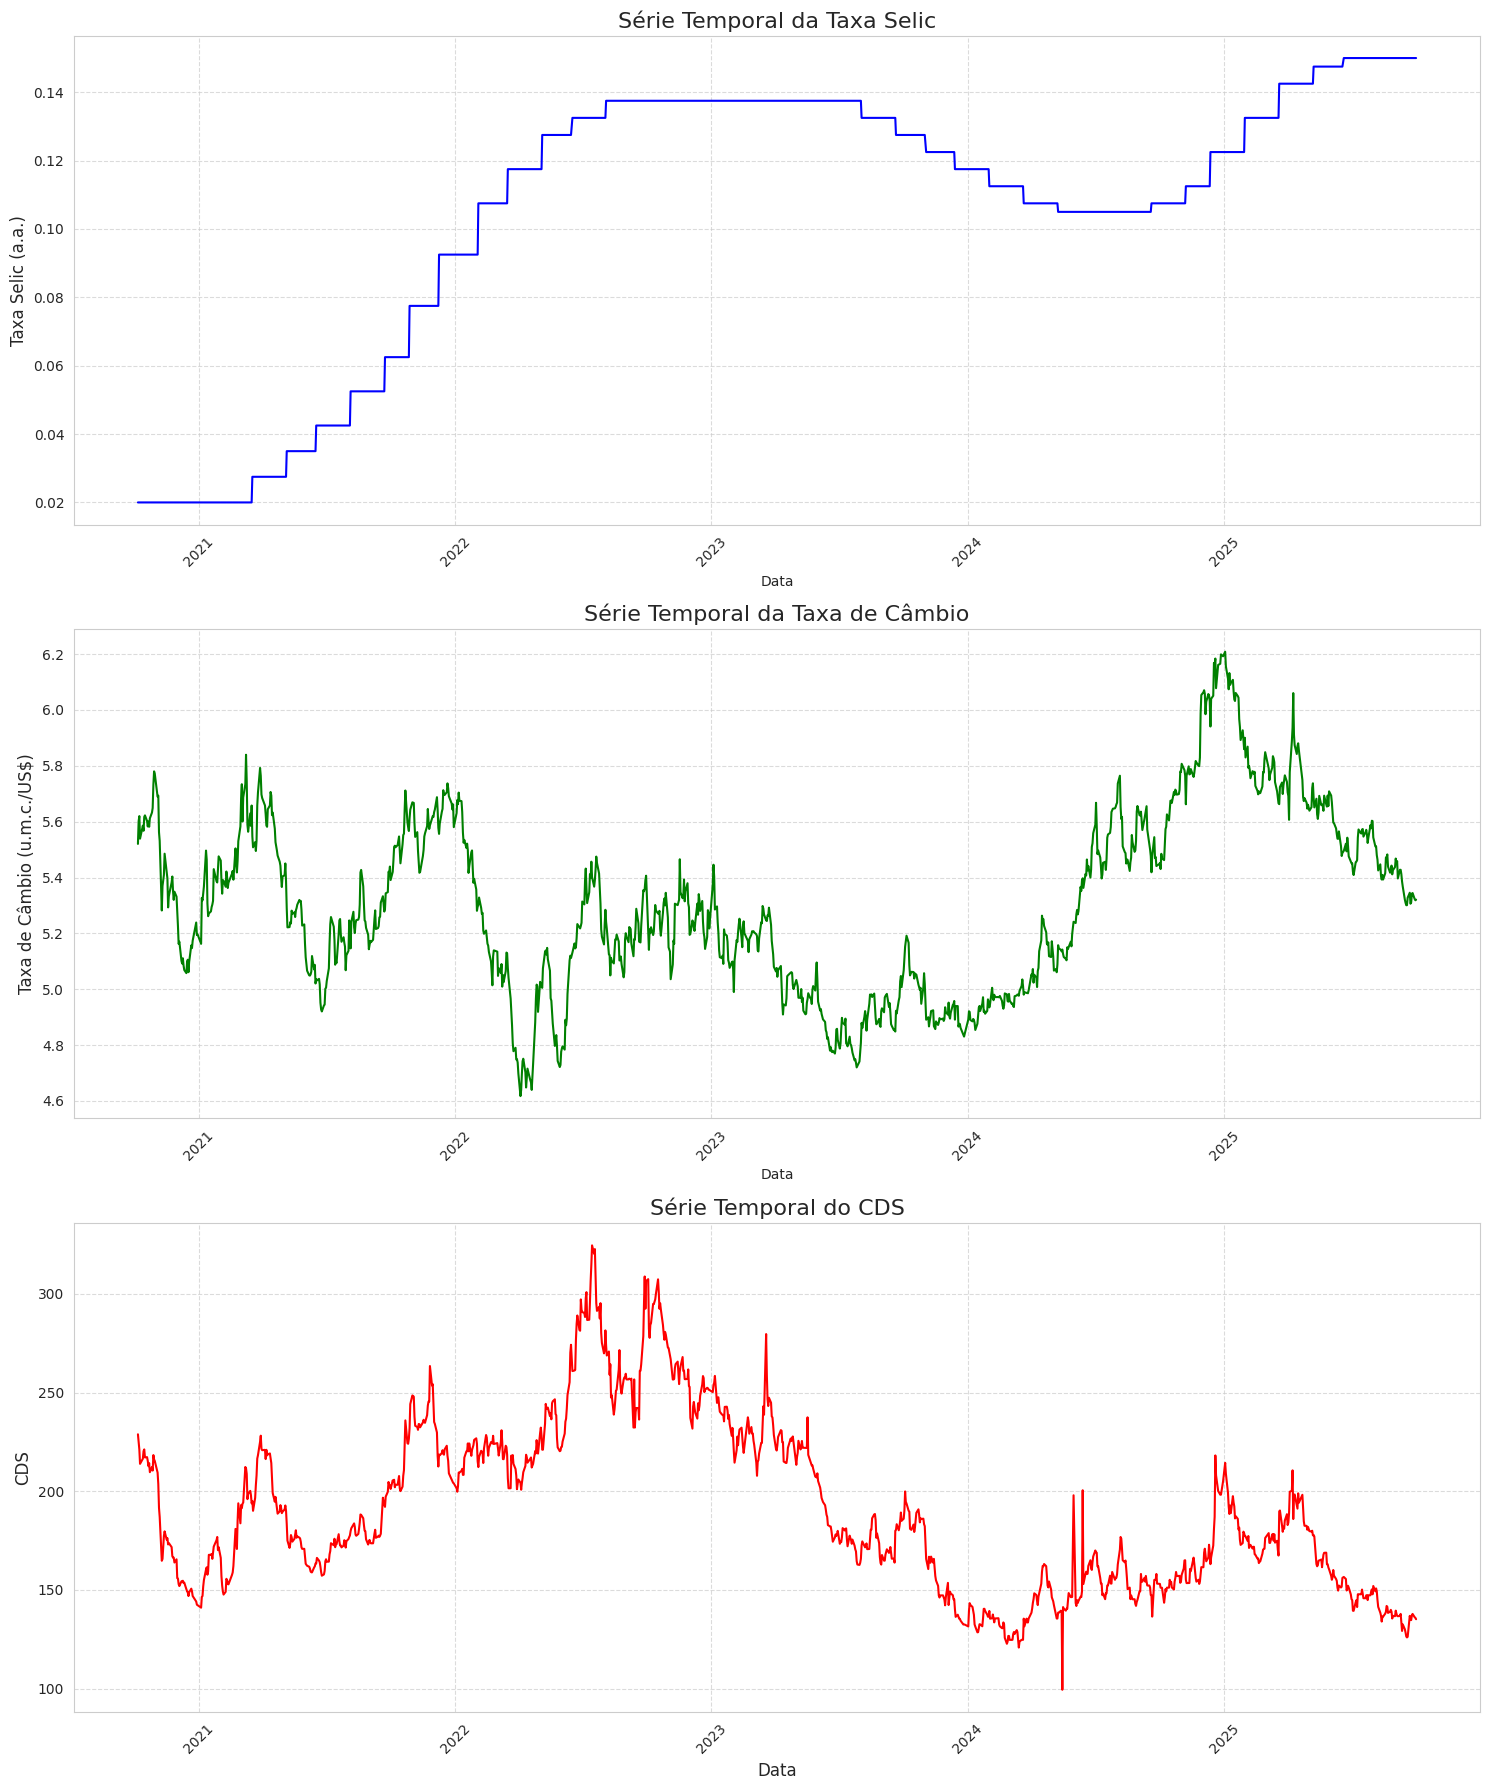

In [210]:
sns.set_style('whitegrid')

fig, axes = plt.subplots(3, 1, figsize=(15, 18), sharex=False)

sns.lineplot(ax=axes[0], x='Data', y='Taxa Selic - a.a.', data=df, color='blue')
axes[0].set_title('Série Temporal da Taxa Selic', fontsize=16)
axes[0].set_ylabel('Taxa Selic (a.a.)', fontsize=12)
axes[0].tick_params(axis='y', labelsize=10)
axes[0].tick_params(axis='x', rotation=45, labelsize=10)
axes[0].grid(True, linestyle='--', alpha=0.7)

sns.lineplot(ax=axes[1], x='Data', y='Taxa Cambio u.m.c./US$', data=df, color='green')
axes[1].set_title('Série Temporal da Taxa de Câmbio', fontsize=16)
axes[1].set_ylabel('Taxa de Câmbio (u.m.c./US$)', fontsize=12)
axes[1].tick_params(axis='y', labelsize=10)
axes[1].tick_params(axis='x', rotation=45, labelsize=10)
axes[1].grid(True, linestyle='--', alpha=0.7)

sns.lineplot(ax=axes[2], x='Data', y='CDS', data=df, color='red')
axes[2].set_title('Série Temporal do CDS', fontsize=16)
axes[2].set_xlabel('Data', fontsize=12)
axes[2].set_ylabel('CDS', fontsize=12)
axes[2].tick_params(axis='x', rotation=45, labelsize=10)
axes[2].tick_params(axis='y', labelsize=10)
axes[2].grid(True, linestyle='--', alpha=0.7)

plt.tight_layout()
plt.show()


###16.2 Gráficos de Série Temporal dos Fatores Macroeconômicos: RETORNO_LOG_CAMBIO, RETORNO_LOG_CDS

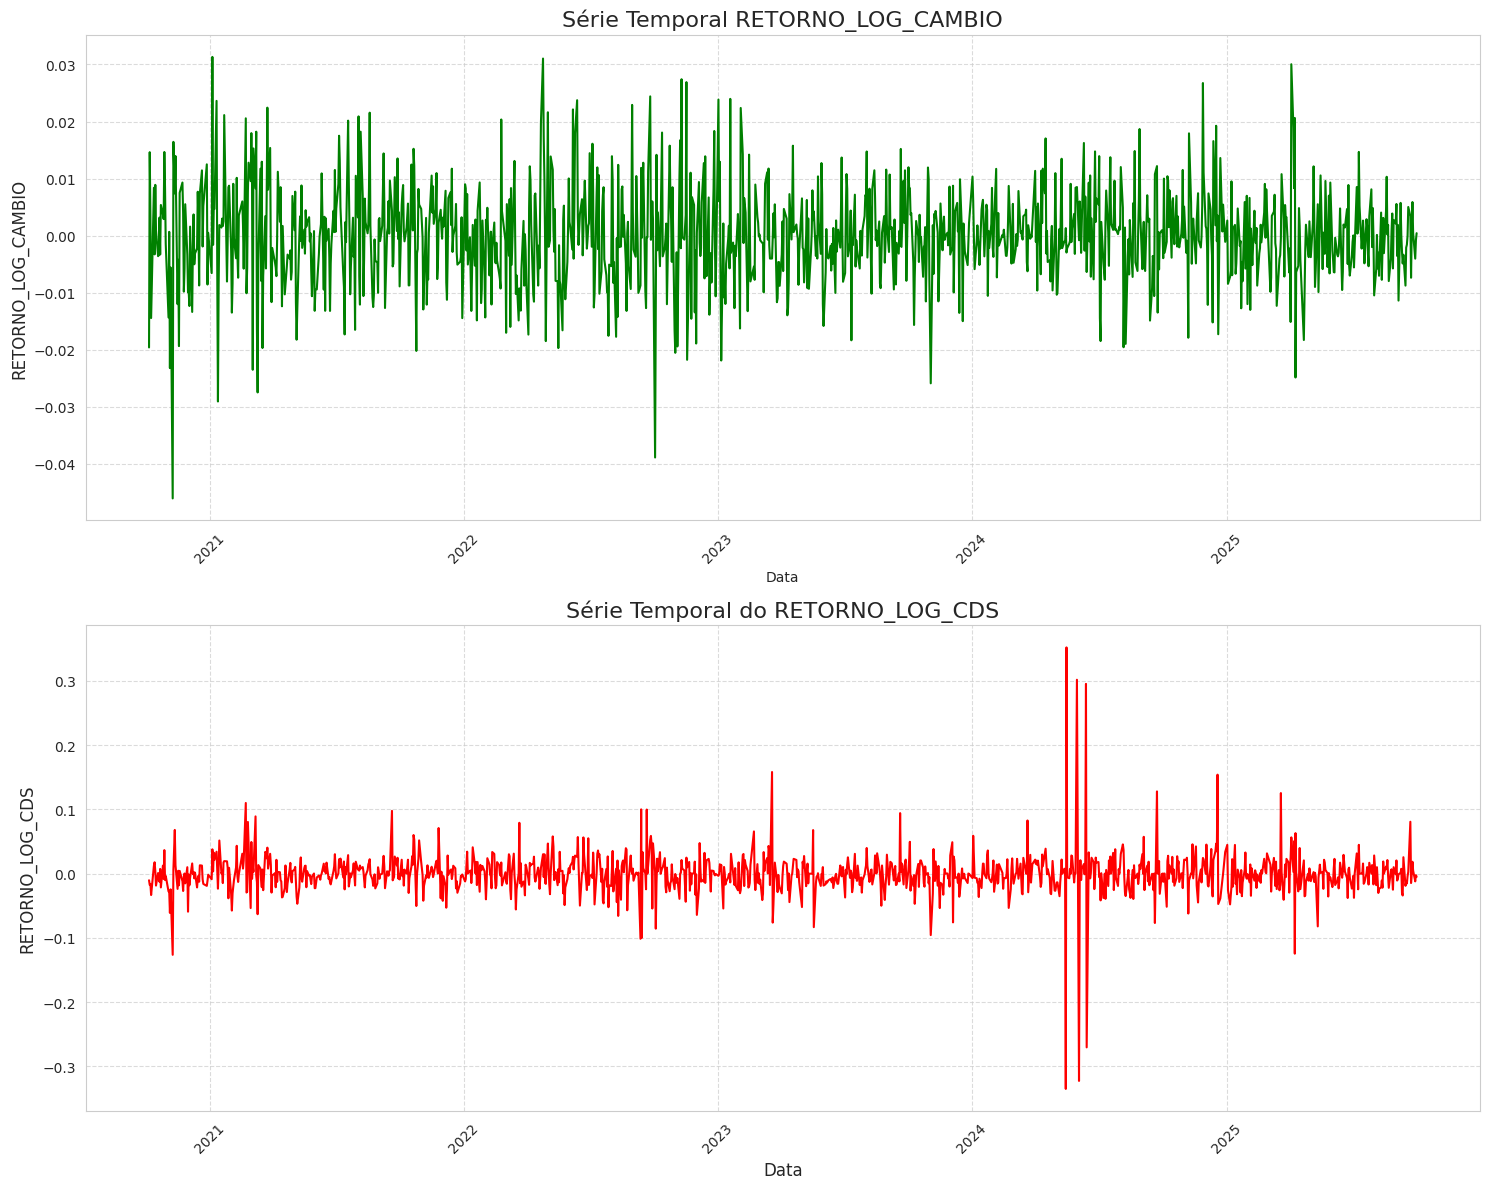

In [211]:
sns.set_style('whitegrid')

fig, axes = plt.subplots(2, 1, figsize=(15, 12), sharex=False) # Criar nova figura e eixos para estes gráficos

sns.lineplot(ax=axes[0], x='Data', y='RETORNO_LOG_CAMBIO', data=df, color='green')
axes[0].set_title('Série Temporal RETORNO_LOG_CAMBIO', fontsize=16)
axes[0].set_ylabel('RETORNO_LOG_CAMBIO', fontsize=12)
axes[0].tick_params(axis='x', rotation=45, labelsize=10)
axes[0].tick_params(axis='y', labelsize=10)
axes[0].grid(True, linestyle='--', alpha=0.7)

sns.lineplot(ax=axes[1], x='Data', y='RETORNO_LOG_CDS', data=df, color='red')
axes[1].set_title('Série Temporal do RETORNO_LOG_CDS', fontsize=16)
axes[1].set_xlabel('Data', fontsize=12)
axes[1].set_ylabel('RETORNO_LOG_CDS', fontsize=12)
axes[1].tick_params(axis='x', rotation=45, labelsize=10)
axes[1].tick_params(axis='y', labelsize=10)
axes[1].grid(True, linestyle='--', alpha=0.7)

plt.tight_layout()
plt.show()

###16.3 Gráficos de Série Temporal dos Preços das Ações

A análise dos gráficos de série temporal dos preços das ações do Itaú (ITUB4), Petrobras (PETR4) e Vale Rio Doce (VALE3):

Itaú (ITUB4)

- Tendência geral de valorização no longo prazo.
- Flutuações com quedas e recuperações ao longo do tempo.
- Volatilidade presente, mas com resiliência.
- Influenciado principalmente pela taxa Selic e pela saúde da economia brasileira.

Petrobras (PETR4)

- Alta volatilidade no gráfico de preços.
- Forte sensibilidade ao Preço internacional do petróleo e Fatores geopolíticos.
- Políticas governamentais e mudanças na gestão.
- Apresenta picos e vales acentuados.
- Tendência mais errática, mas com potenciais ganhos em períodos favoráveis ao petróleo.

Vale (VALE3)

- Volatilidade típica do setor de commodities.
- Influências: Demanda minério de ferro e variação cambial (dólar).
- Gráfico com fortes altas e quedas, mas tendência de valorização no longo prazo.
- Forte correlação com o ciclo global de commodities.



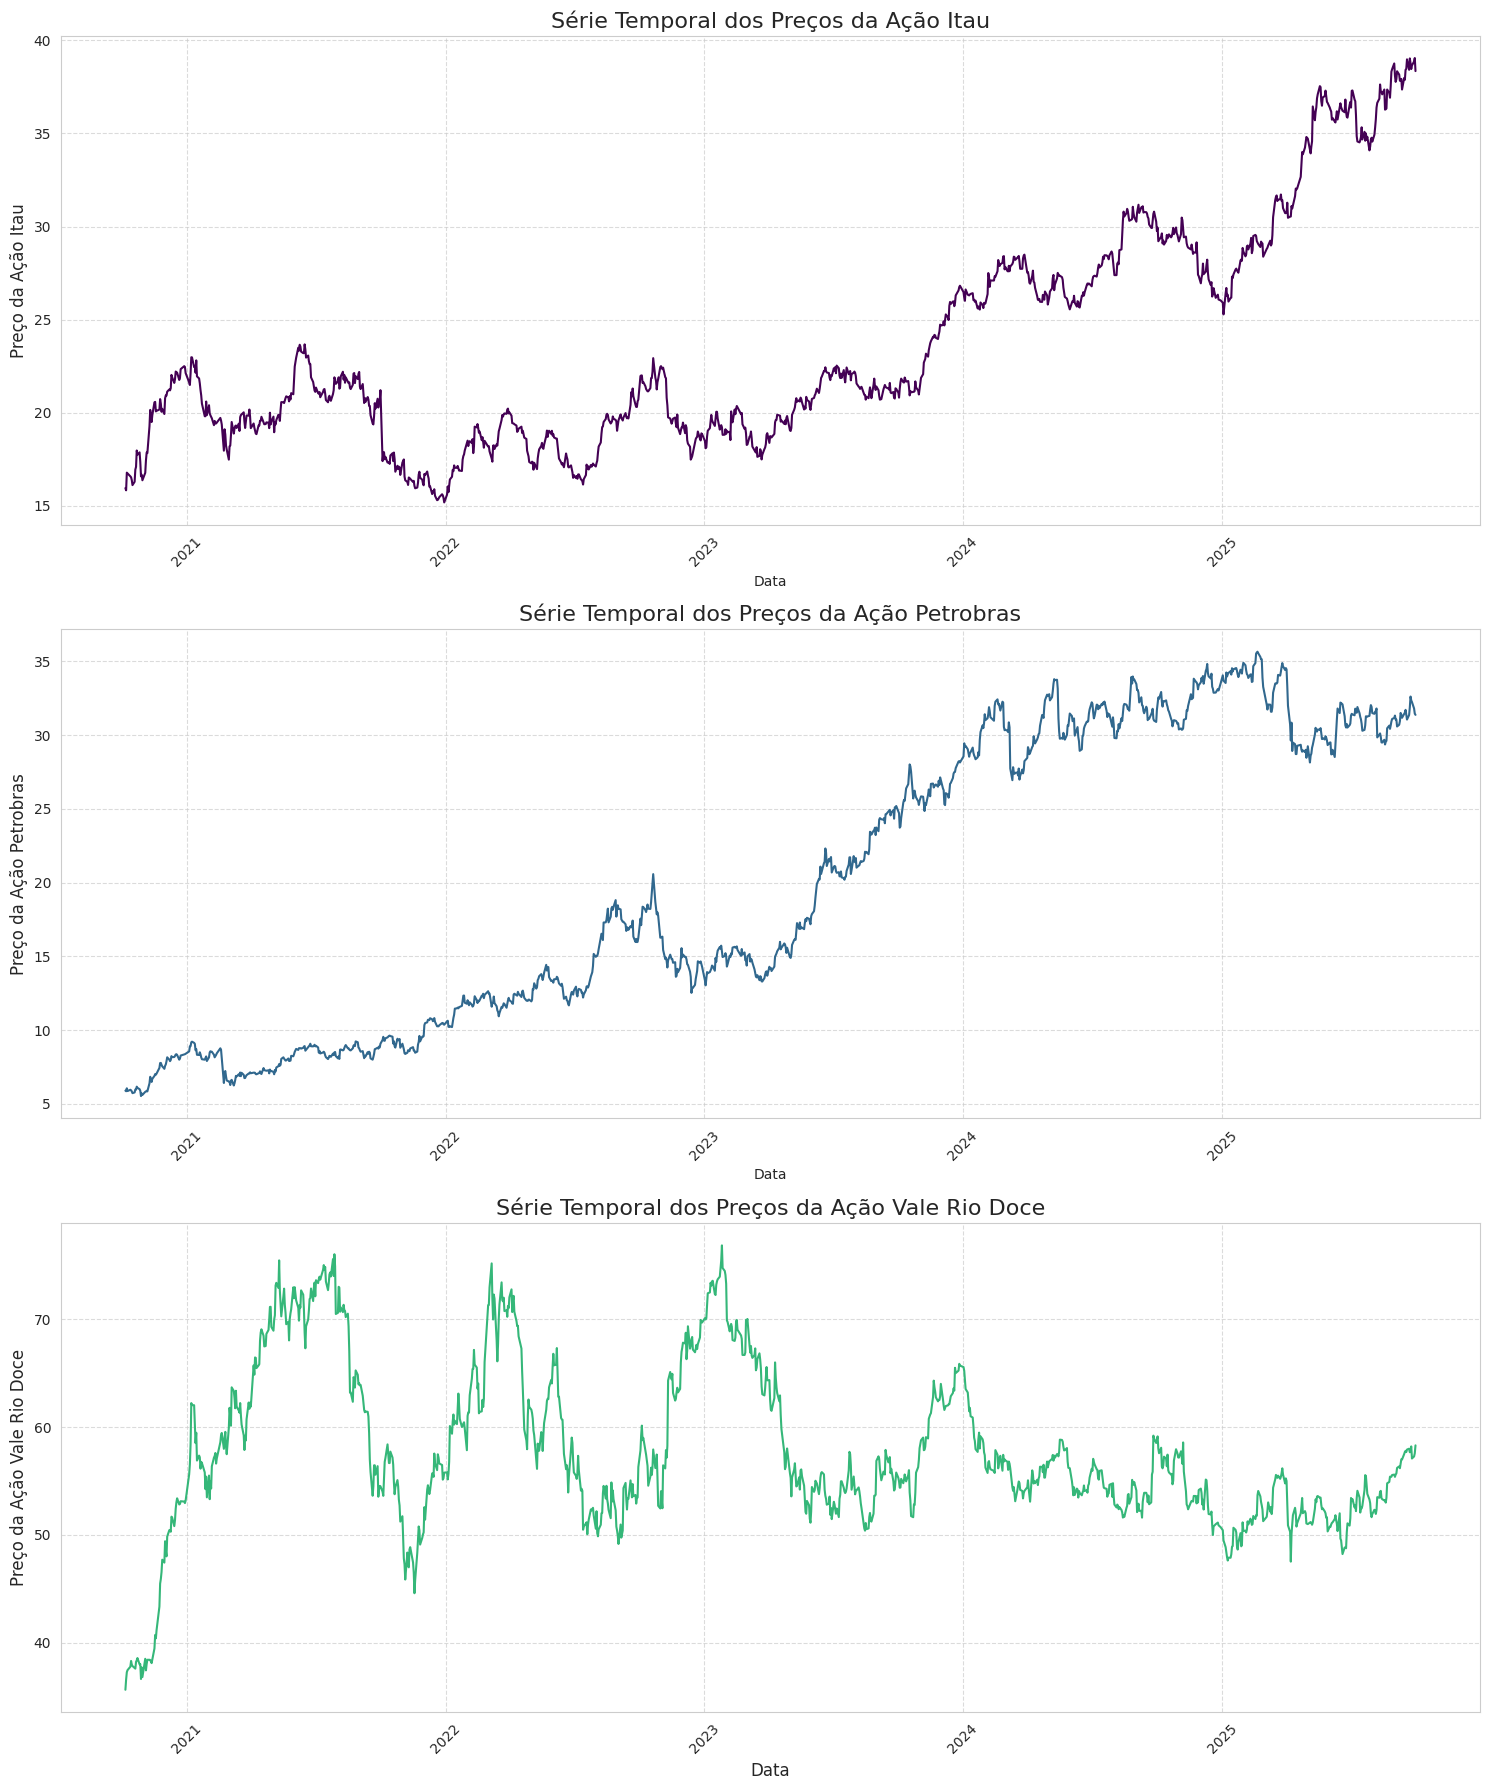

In [212]:
acoes_precos = ['Itau', 'Petrobras', 'Vale Rio Doce']

fig, axes = plt.subplots(3, 1, figsize=(15, 18), sharex=False)

for i, acao in enumerate(acoes_precos):
    sns.lineplot(ax=axes[i], x='Data', y=acao, data=df, color=plt.cm.viridis(i/len(acoes_precos)))
    axes[i].set_title(f'Série Temporal dos Preços da Ação {acao}', fontsize=16)
    axes[i].set_ylabel(f'Preço da Ação {acao}', fontsize=12)
    axes[i].tick_params(axis='x', rotation=45, labelsize=10)
    axes[i].tick_params(axis='y', labelsize=10)

    axes[i].grid(True, linestyle='--', alpha=0.7)

axes[-1].set_xlabel('Data', fontsize=12)

plt.tight_layout()
plt.show()

###16.4 Gráficos de Série Temporal do Retorno logaritmo dos Preços das Ações

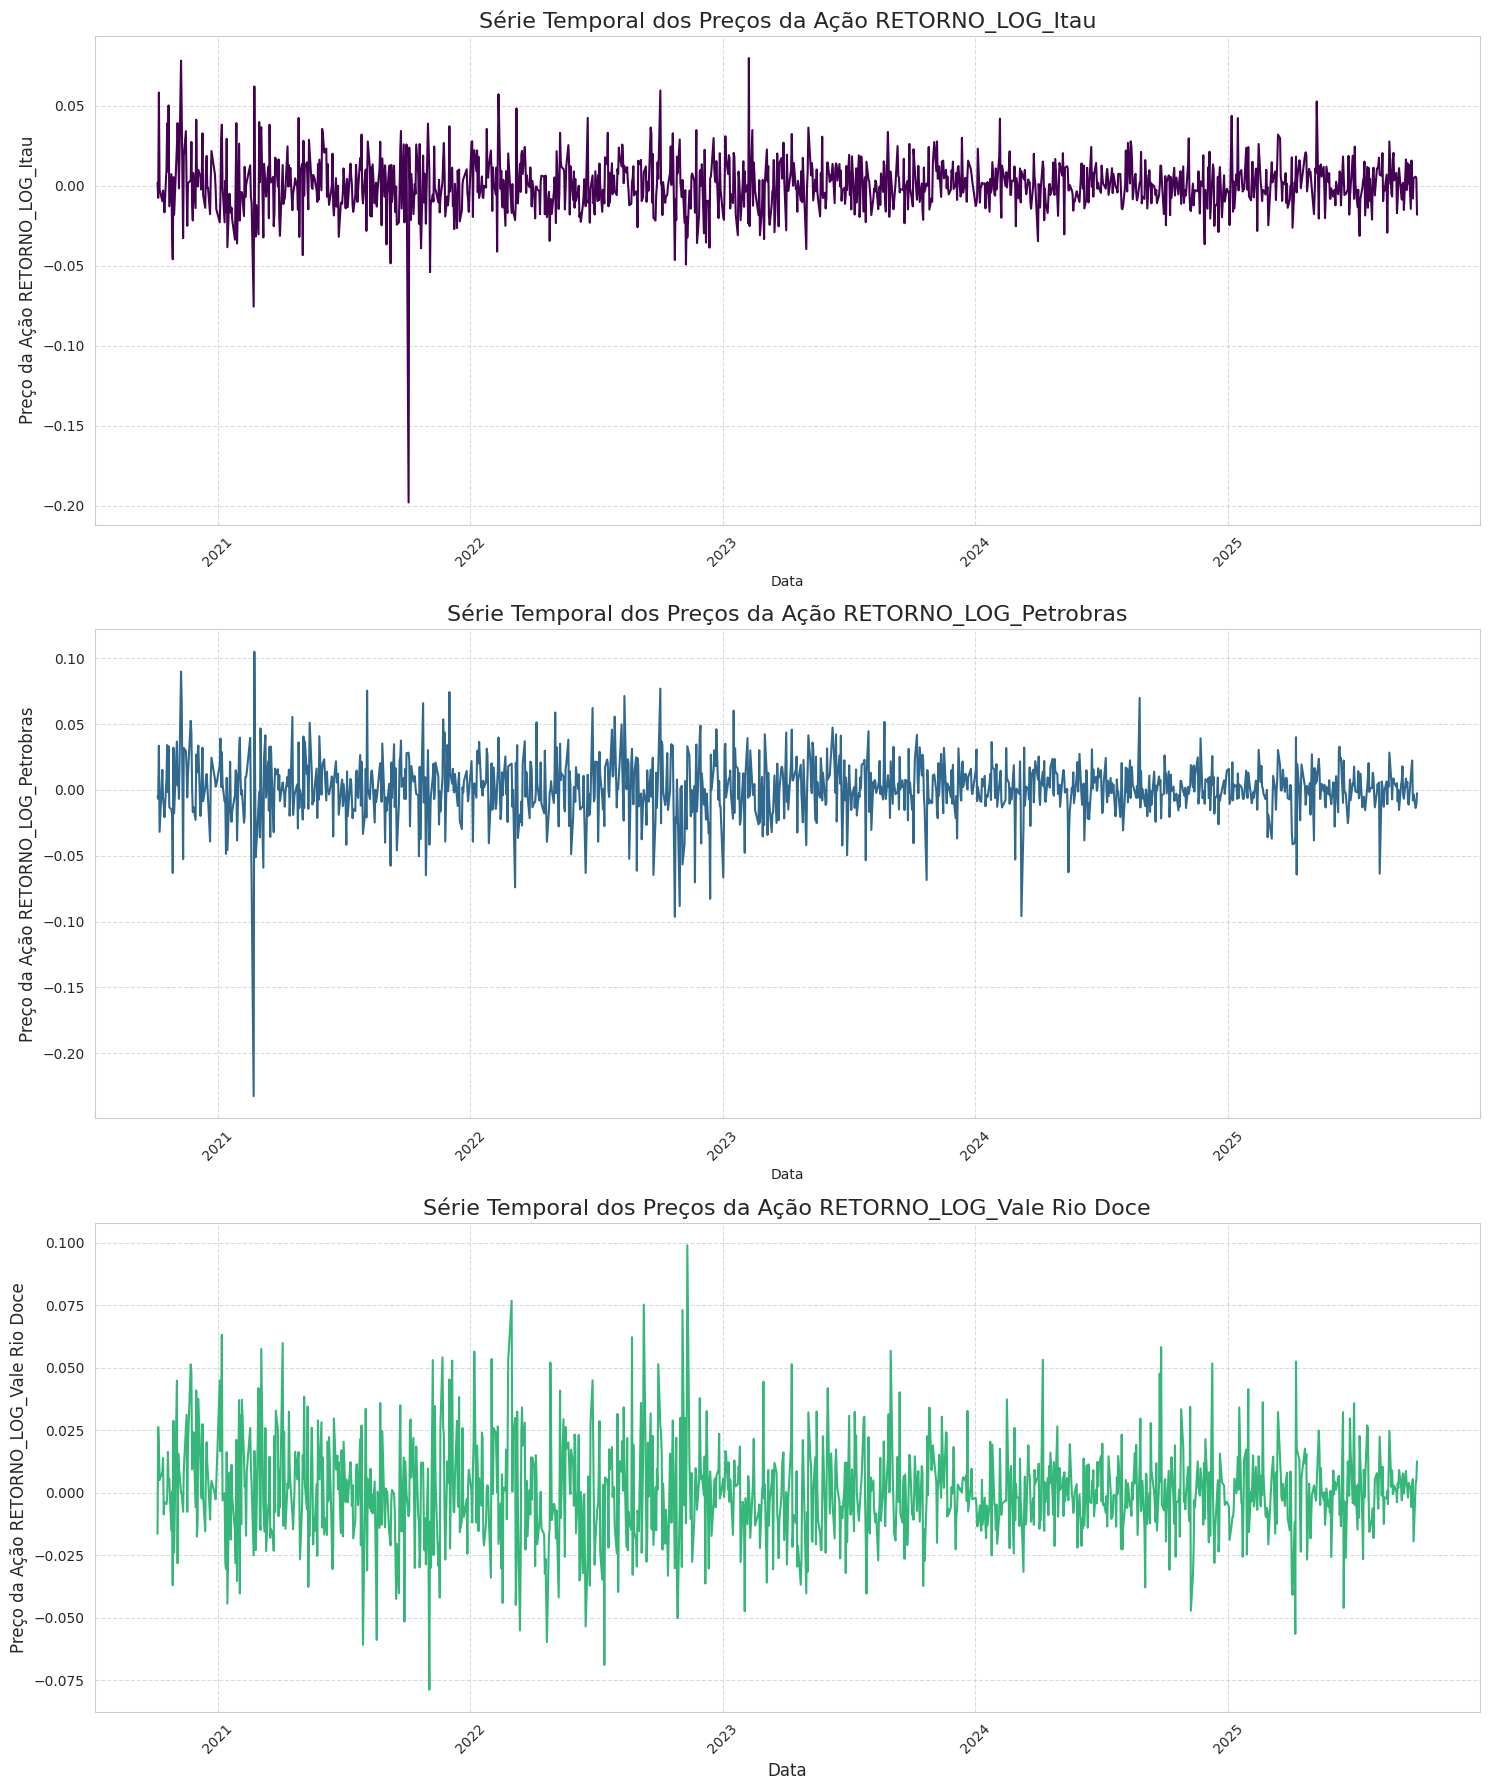

In [213]:
acoes_precos = ['RETORNO_LOG_Itau', 'RETORNO_LOG_Petrobras', 'RETORNO_LOG_Vale Rio Doce']

fig, axes = plt.subplots(3, 1, figsize=(15, 18), sharex=False)

for i, acao in enumerate(acoes_precos):
    sns.lineplot(ax=axes[i], x='Data', y=acao, data=df, color=plt.cm.viridis(i/len(acoes_precos)))
    axes[i].set_title(f'Série Temporal dos Preços da Ação {acao}', fontsize=16)
    axes[i].set_ylabel(f'Preço da Ação {acao}', fontsize=12)
    axes[i].tick_params(axis='x', rotation=45, labelsize=10)
    axes[i].tick_params(axis='y', labelsize=10)
    axes[i].grid(True, linestyle='--', alpha=0.7)

axes[-1].set_xlabel('Data', fontsize=12)
axes[-1].tick_params(axis='x', rotation=45, labelsize=10)

plt.tight_layout()
plt.show()

###16.5 Correlação

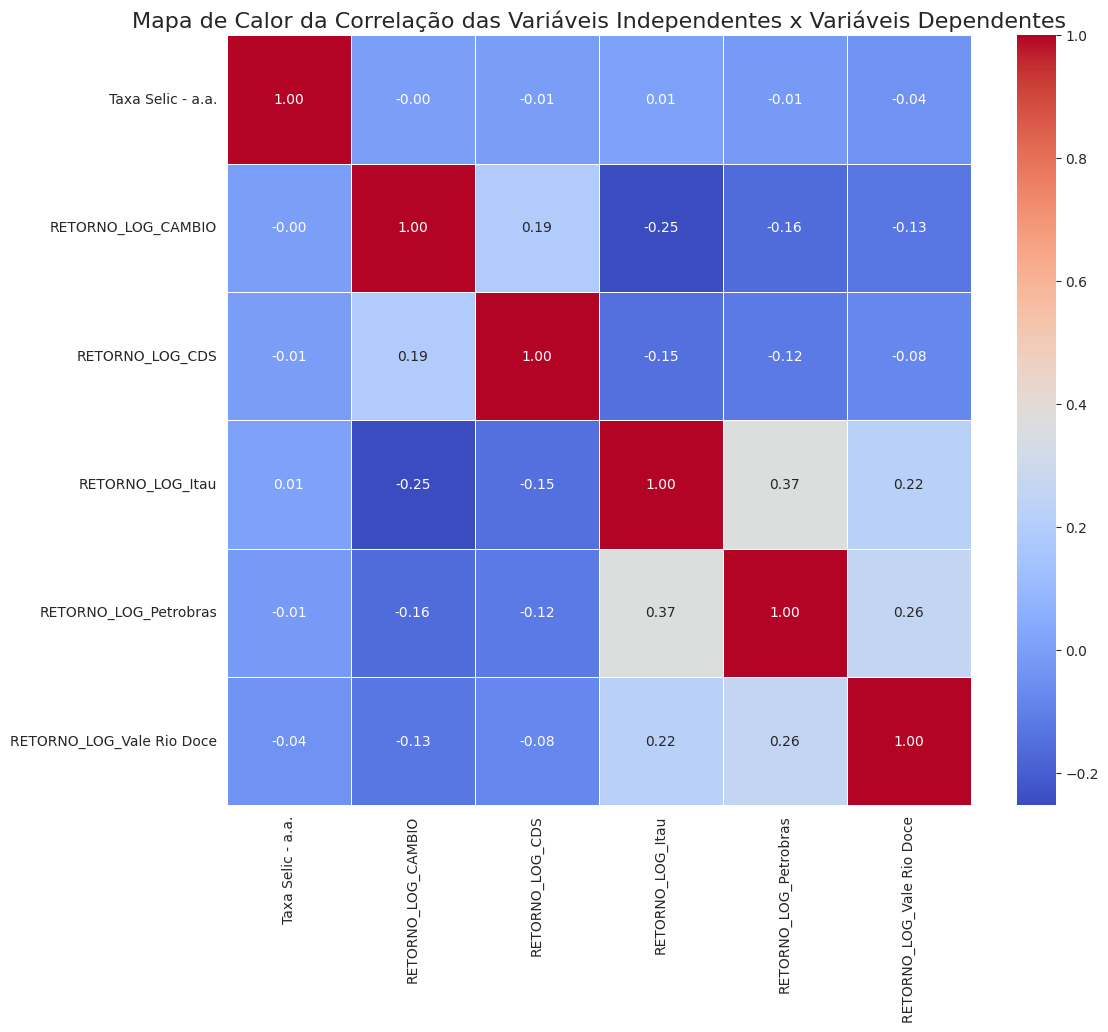

In [214]:
correlation_matrix = df[['Taxa Selic - a.a.', 'RETORNO_LOG_CAMBIO', 'RETORNO_LOG_CDS', 'RETORNO_LOG_Itau', 'RETORNO_LOG_Petrobras', 'RETORNO_LOG_Vale Rio Doce']].corr()

# Criar o mapa de calor
plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=.5)
plt.title('Mapa de Calor da Correlação das Variáveis Independentes x Variáveis Dependentes', fontsize=16)
plt.show()

##16.5.1 Analisando a Correlação
Importante:
- Variáveis independentes: Taxa Selic - a.a., Retorno Logaritmo Cambio e Retorno Logaritmo CDS
- Variáveis dependentes: Retorno Logaritmo Itau, Retorno Logaritmo Petrobras, Retorno Logaritmo Vale Rio Doce (Retorno Logaritmo das ações das empresas)

Comportamento?
- Por exemplo, a medida que aumento o valor do cambio e/ou do risco CDS, o retorno logaritmo do preço das ações das empresas Itau, Petrobrás e Vale do Rio Doce tendem a diminuir.

////GRAFICOS AQUI FIM!!

##17 MODELO DE REGRESSÃO MULTIPLA: RODAR REGRESSÃO PARA CADA AÇÃO

###17.1 Considerar todas as variáveis (Selic, Cambio, CDS)

In [215]:
acoes_retorno = ['RETORNO_LOG_Itau', 'RETORNO_LOG_Petrobras', 'RETORNO_LOG_Vale Rio Doce']

for y_var in acoes_retorno:
    Y = df[y_var]

    model = sm.OLS(Y, X).fit()

    print(f"\n--- Resultados da Regressão para {y_var} ---")
    print(model.summary())


--- Resultados da Regressão para RETORNO_LOG_Itau ---
                            OLS Regression Results                            
Dep. Variable:       RETORNO_LOG_Itau   R-squared:                       0.074
Model:                            OLS   Adj. R-squared:                  0.072
Method:                 Least Squares   F-statistic:                     32.86
Date:                Wed, 10 Dec 2025   Prob (F-statistic):           1.95e-20
Time:                        13:44:23   Log-Likelihood:                 3358.2
No. Observations:                1241   AIC:                            -6708.
Df Residuals:                    1237   BIC:                            -6688.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------

Fator macroeconomico (Selic + Cambio + CDS):
- Essa combinação não é válida, pois o a regra do 'p estatítico' deve ser atendida: p < 0.05. Exemplo: Para a Vale do Rio Doce, a Taxa Selic a.a. teve p =~ 0.10

##17.2 Removendo apenas coluna da taxa Selic

In [216]:
X_less_selic = df[['RETORNO_LOG_CAMBIO', 'RETORNO_LOG_CDS']]
X_less_selic = sm.add_constant(X_less_selic)

acoes_retorno = ['RETORNO_LOG_Itau', 'RETORNO_LOG_Petrobras', 'RETORNO_LOG_Vale Rio Doce']

for y_var in acoes_retorno:
    Y = df[y_var]

    model_less_selic = sm.OLS(Y, X_less_selic).fit()

    print(f"\n--- Resultados da Regressão para {y_var} (Apenas Risco Brasil (CDS) e Cambio) ---")
    print(model_less_selic.summary())


--- Resultados da Regressão para RETORNO_LOG_Itau (Apenas Risco Brasil (CDS) e Cambio) ---
                            OLS Regression Results                            
Dep. Variable:       RETORNO_LOG_Itau   R-squared:                       0.074
Model:                            OLS   Adj. R-squared:                  0.072
Method:                 Least Squares   F-statistic:                     49.31
Date:                Wed, 10 Dec 2025   Prob (F-statistic):           2.48e-21
Time:                        13:44:23   Log-Likelihood:                 3358.1
No. Observations:                1241   AIC:                            -6710.
Df Residuals:                    1238   BIC:                            -6695.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                         coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------

Fator macroeconomico (Cambio + CDS):
- Essa combinação é válida para todos os casos (p < 0.05) com poder explicativo maior para o Itaú ($R^2$ Ajustado =~ 0.08).

##17.3 Removendo apenas a Taxa de cambio

In [217]:
X_less_cambio = df[['Taxa Selic - a.a.', 'RETORNO_LOG_CDS']]
X_less_cambio = sm.add_constant(X_less_cambio)

acoes_retorno = ['RETORNO_LOG_Itau', 'RETORNO_LOG_Petrobras', 'RETORNO_LOG_Vale Rio Doce']

for y_var in acoes_retorno:
    Y = df[y_var]

    model_less_cambio = sm.OLS(Y, X_less_cambio).fit()

    print(f"\n--- Resultados da Regressão para {y_var} (Apenas Risco Brasil (CDS) e Selic) ---")
    print(model_less_cambio.summary())


--- Resultados da Regressão para RETORNO_LOG_Itau (Apenas Risco Brasil (CDS) e Selic) ---
                            OLS Regression Results                            
Dep. Variable:       RETORNO_LOG_Itau   R-squared:                       0.021
Model:                            OLS   Adj. R-squared:                  0.020
Method:                 Least Squares   F-statistic:                     13.41
Date:                Wed, 10 Dec 2025   Prob (F-statistic):           1.72e-06
Time:                        13:44:23   Log-Likelihood:                 3323.9
No. Observations:                1241   AIC:                            -6642.
Df Residuals:                    1238   BIC:                            -6626.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------

Fator macroeconomico (Selic + CDS):

- Essa combinação não é válida, pois o a regra do 'p estatítico' deve ser atendida: p < 0.05.


##17.4 Ultimo teste, removendo as colunas Selic, Cambio e mantendo Risco Brasil (CDS)

In [218]:
X_cds_only = df[['RETORNO_LOG_CDS']]
X_cds_only = sm.add_constant(X_cds_only)

acoes_retorno = ['RETORNO_LOG_Itau', 'RETORNO_LOG_Petrobras', 'RETORNO_LOG_Vale Rio Doce']

for y_var in acoes_retorno:
    Y = df[y_var]

    model_cds_only = sm.OLS(Y, X_cds_only).fit()

    print(f"\n--- Resultados da Regressão para {y_var} (Apenas Risco Brasil (CDS)) ---")
    print(model_cds_only.summary())


--- Resultados da Regressão para RETORNO_LOG_Itau (Apenas Risco Brasil (CDS)) ---
                            OLS Regression Results                            
Dep. Variable:       RETORNO_LOG_Itau   R-squared:                       0.021
Model:                            OLS   Adj. R-squared:                  0.020
Method:                 Least Squares   F-statistic:                     26.81
Date:                Wed, 10 Dec 2025   Prob (F-statistic):           2.62e-07
Time:                        13:44:23   Log-Likelihood:                 3323.9
No. Observations:                1241   AIC:                            -6644.
Df Residuals:                    1239   BIC:                            -6633.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------

Fator macroeconomico (CDS):

Essa combinação é válida para todos os casos (p < 0.05), mas o poder explicativo $R^2$ Ajustado é muito pequeno.

#17.5 Considerações finais

A combinação (Cambio + CDS) foi considerada pois:
- oferece o melhor equilíbrio entre simplicidade e capacidade de explicar a variação nos retornos das ações.
- Ambas as variáveis,  (RETORNO_LOG_CAMBIO e RETORNO_LOG_CDS são estatisticamente significativas (p < 0.05) para os três ativos.
- Multicolinearidade aceitável: A multicolinearidade (Cond. No. $\approx 121$) entre Câmbio e CDS indica que eles se movem juntos, dificultando a interpretação isolada do efeito de cada um, porém não a capacidade preditiva do modelo como um todo

///

##18 Salvar o modelo preditivo e seus resultados em arquivo JSON -> App Flutter

In [219]:
resultados_finais = {}

acoes_retorno = ['RETORNO_LOG_Itau', 'RETORNO_LOG_Petrobras', 'RETORNO_LOG_Vale Rio Doce']

for y_var in acoes_retorno:
    Y = df[y_var]

    model = sm.OLS(Y, X_less_selic).fit()

    ticker = y_var.replace('RETORNO_LOG_', '')

    df_results = model.params.to_frame(name='Coeficiente')
    df_results['P_Valor'] = model.pvalues

    coeficientes = {}
    for index, row in df_results.iterrows():
        coeficientes[index] = {
            "beta": round(row['Coeficiente'], 4),
            "p_valor": round(row['P_Valor'], 4),
            "significativo": bool(row['P_Valor'] < 0.05)
        }

    resultados_finais[ticker] = {
        "metrics": {
            "r_squared_ajustado": round(model.rsquared_adj, 4),
            "f_pvalue": round(model.f_pvalue, 4)
        },
        "fatores": coeficientes
    }

with open('model_results.json', 'w') as f:
    json.dump(resultados_finais, f, indent=4)

print("Resultados salvos em 'model_results.json'. Este arquivo será usado pelo Flutter.")


Resultados salvos em 'model_results.json'. Este arquivo será usado pelo Flutter.


##Download do arquivo JSON

In [220]:
files.download('model_results.json')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>